In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
from xgboost.sklearn import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
import shap
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay
%matplotlib inline

In [112]:
df_rootDataset = pd.read_csv("./data/rootDataset.csv")

In [113]:
for col in df_rootDataset.columns:
    print(col)

icustay_id
urineoutput
age
pulmonary
vent
heartrate_min
heartrate_max
heartrate_mean
sysbp_min
sysbp_max
sysbp_mean
diasbp_min
diasbp_max
diasbp_mean
meanbp_min
meanbp_max
meanbp_mean
resprate_min
resprate_max
resprate_mean
tempc_min
tempc_max
tempc_mean
spo2_min
spo2_max
spo2_mean
glucose_mean
mingcs
gcsmotor
gcsverbal
gcseyes
endotrachflag
aniongap_min
aniongap_max
albumin_min
albumin_max
bands_min
bands_max
bicarbonate_min
bicarbonate_max
bilirubin_min
bilirubin_max
creatinine_min
creatinine_max
chloride_min
chloride_max
glucose_min
glucose_max
hematocrit_min
hematocrit_max
hemoglobin_min
hemoglobin_max
lactate_min
lactate_max
platelet_min
platelet_max
potassium_min
potassium_max
ptt_min
ptt_max
inr_min
inr_max
pt_min
pt_max
sodium_min
sodium_max
bun_min
bun_max
wbc_min
wbc_max
specimen
specimen_pred
specimen_prob
so2
spo2
po2
pco2
fio2_chartevents
fio2
aado2
aado2_calc
pao2fio2
ph
baseexcess
bicarbonate
totalco2
hematocrit
hemoglobin
carboxyhemoglobin
methemoglobin
chloride
calcium

In [114]:
medical_score_features = [['GCS','Heart rate',' mean blood pressure','temperature','respiration rate','ventilation/cpap','chronic dialysis','urine output','Pao2','A-aDO2','hematocrit','WBC','creatinine','blood urea nitrogen','sodium','albumin','bilirubin','glucose','pH','pCO2'],            ['GCS','Heart rate','systolic blood pressure','ventilation/cpap','urine output','blood urea nitrogen','WBC','bilirubin','creatinine','prothrombin time (PT)','platelets','PaO2/FiO2 ratio',],                                                                  
                          ['GCS','Heart rate','systolic blood pressure','ventilation/cpap','WBC',' bilirubin','creatinine','platelets','PaO2/FiO2 ratio'],                                                                                                                                
                          ['Heart rate','GCS','MAP','temperature','respiration rate','Ventilation status','urine output','Elective surgery','Pre-ICU in-hospital length of stay','Age'],                                                                                                  
                          ['GCS','respiration rate','systolic blood pressure'],                                                                                                                                                                                                           
                          ['Age','GCS','Heart rate','systolic blood pressure','temperature','respiration rate','ventilation/cpap','urine output','blood urea nitrogen','hematocrit','WBC','glucose','potassium','sodium','HCO3'],                                                         
                          ['Age','GCS','Heart rate','systolic blood pressure','temperature','ventilation/cpap','urine output','PaO2/FiO2 ratio','blood urea nitrogen','WBC','potassium','sodium','HCO3'],                                                                                
                          ['Body temperature','Heart rate','respiration rate','PaCO2','White blood cell count'],                                                                                                                                                                           
                          ['GCS','MAP','FiO2','Ventilation status','Creatinine','Bilirubin','PaO2','Platelets','Dobutamine','Epinephrine','Norepinephrine','urine output']]

In [115]:
df_fpm = pd.DataFrame([df_rootDataset["bilirubin_min"], df_rootDataset["age"], df_rootDataset["heartrate_mean"], df_rootDataset["meanbp_mean"], df_rootDataset["wbc_min"], df_rootDataset["wbc_max"], df_rootDataset["pco2"], df_rootDataset["pao2fio2"], df_rootDataset["mingcs"], df_rootDataset["temperature"], df_rootDataset["los"], df_rootDataset["sysbp_mean"], df_rootDataset["glucose_mean"], df_rootDataset["sodium_min"], df_rootDataset["sodium_max"], df_rootDataset["creatinine_min"], df_rootDataset["creatinine_max"], df_rootDataset["platelet_min"], df_rootDataset["platelet_max"], df_rootDataset["urineoutput"], df_rootDataset["icu_level"]]).transpose()
for col in df_fpm:
    print(col)

bilirubin_min
age
heartrate_mean
meanbp_mean
wbc_min
wbc_max
pco2
pao2fio2
mingcs
temperature
los
sysbp_mean
glucose_mean
sodium_min
sodium_max
creatinine_min
creatinine_max
platelet_min
platelet_max
urineoutput
icu_level


In [116]:
# df_fpm["creatinine_avg"] = df_fpm[['creatinine_min', 'creatinine_max']].mean(axis=1)
# df_fpm["sodium_avg"] = df_fpm[['sodium_min', 'sodium_max']].mean(axis=1)
# df_fpm["wbc_avg"] = df_fpm[['wbc_min', 'wbc_max']].mean(axis=1)

In [117]:
df_fpm.pop("wbc_min")
# df_fpm.pop("wbc_max")
df_fpm.pop("sodium_min")
# df_fpm.pop("sodium_max")
df_fpm.pop("creatinine_min")
# df_fpm.pop("creatinine_max")
df_fpm.pop("platelet_min")
df_fpm.pop("platelet_max")
df_fpm.pop("mingcs")
df_fpm.pop("sysbp_mean")

0         103.423077
1         103.423077
2         103.423077
3         103.423077
4         103.181818
             ...    
164179    104.464286
164180    104.464286
164181    104.464286
164182    104.464286
164183    104.464286
Name: sysbp_mean, Length: 164184, dtype: float64

In [118]:
epochs = 20
param = {
    'eta':0.5,
    'objective': 'multi:softmax',
    'num_class': 4
}
xgb_class = XGBClassifier(param, num_boost_round=epochs, nfold=5,
             metrics={'merror'}, seed=0)
xgb_class            

Pass `objective` as keyword args.  Passing these as positional arguments will be considered as error in future releases.


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, gamma=None,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, metrics={'merror'}, min_child_weight=None,
              missing=nan, monotone_constraints=None, n_estimators=100,
              n_jobs=None, nfold=5, num_boost_round=20, num_parallel_tree=None,
              objective={'eta': 0.5, 'num_class': 4,
                         'objective': 'multi:softmax'}, ...)

In [119]:
target = df_fpm.pop("icu_level")

In [120]:
print(df_fpm.columns)
print(df_fpm.shape)

Index(['bilirubin_min', 'age', 'heartrate_mean', 'meanbp_mean', 'wbc_max',
       'pco2', 'pao2fio2', 'temperature', 'los', 'glucose_mean', 'sodium_max',
       'creatinine_max', 'urineoutput'],
      dtype='object')
(164184, 13)


In [121]:
le = LabelEncoder()
target = le.fit_transform(target)
target

array([1, 1, 1, ..., 0, 0, 0], dtype=int64)

In [122]:
X_train, X_test, y_train, y_test = train_test_split(df_fpm, target, test_size=0.33, random_state=42)

In [123]:
xgb_class.fit(X_train, y_train)

[17:29:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "metrics", "nfold", "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, metrics={'merror'},
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, nfold=5, num_boost_round=20,
              num_parallel_tree=1, objective='multi:softprob', ...)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check th

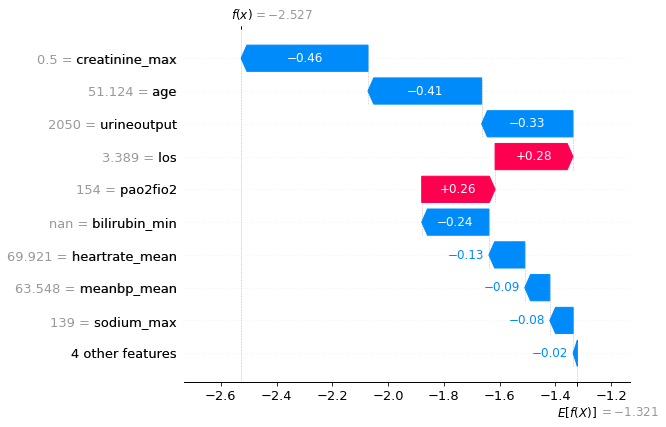

In [124]:
background = shap.maskers.Independent(X_train, max_samples=100)
def f(x):
    return shap.links.identity(xgb_class.predict_proba(x, validate_features=False)[:,1])
explainer = shap.Explainer(f, background, link=shap.links.logit)
shap_values = explainer(X_train[:100])


shap.plots.waterfall(shap_values[0])

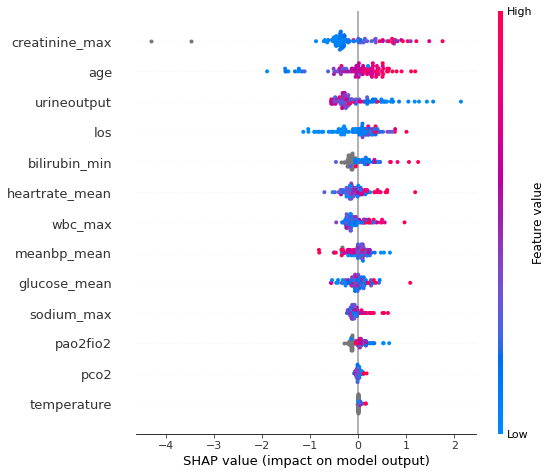

In [125]:
shap.summary_plot(shap_values, X_train[:100])

In [126]:
y_predicted = xgb_class.predict(X_test)

In [127]:
y_test

array([0, 1, 0, ..., 0, 0, 0], dtype=int64)

In [128]:
acc = accuracy_score(y_test,y_predicted)
print("Model Accuracy :", acc)

Model Accuracy : 0.8815636477732046


In [129]:
df_fpm.columns

Index(['bilirubin_min', 'age', 'heartrate_mean', 'meanbp_mean', 'wbc_max',
       'pco2', 'pao2fio2', 'temperature', 'los', 'glucose_mean', 'sodium_max',
       'creatinine_max', 'urineoutput'],
      dtype='object')

In [130]:
df_externalVal = pd.read_csv("./data/externalvalidation.csv")
for col in df_externalVal.columns:
    print(col)

patientunitstayid
apacheapsvarid
intubated
vent
dialysis
eyes
motor
verbal
meds
urine
wbc
temperature
respiratoryrate
sodium
heartrate
meanbp
ph
hematocrit
albumin
pco2
bun
glucose
bilirubin
apachepatientsresultsid
physicianspeciality
physicianinterventioncategory
acutephysiologyscore
apachescore
apacheversion
predictedicumortality
actualicumortality
predictediculos
actualiculos
predictedhospitalmortality
actualhospitalmortality
predictedhospitallos
actualhospitallos
preopmi
preopcardiaccath
ptcawithin24h
unabridgedunitlos
unabridgedhosplos
actualventdays
predventdays
unabridgedactualventdays
apachepredvarid
sicuday
saps3day1
saps3today
saps3yesterday
gender
teachtype
region
bedcount
admitsource
graftcount
age
admitdiagnosis
thrombolytics
diedinhospital
aids
hepaticfailure
lymphoma
metastaticcancer
leukemia
immunosuppression
cirrhosis
electivesurgery
activetx
readmit
ima
midur
ventday1
oobventday1
oobintubday1
diabetes
managementsystem
var03hspxlos
pao2
fio2
ejectfx
creatinine
discharg

In [131]:
df_externalVal.shape

(1069, 91)

In [132]:
df_externalVal.drop_duplicates(subset="patientunitstayid")
df_externalVal.shape

(1069, 91)

In [151]:
df_fpmExternalValidation = pd.DataFrame(
[
    df_externalVal["bilirubin"],
    df_externalVal["albumin"],
    df_externalVal["age"],
    df_externalVal["heartrate"], 
    df_externalVal["meanbp"],
    df_externalVal["wbc"],
    df_externalVal["pco2"],
    df_externalVal["day1pao2"],
    df_externalVal["day1fio2"],
    df_externalVal["actualiculos"],
    df_externalVal["glucose"],
    df_externalVal["temperature"],
    df_externalVal["sodium"],
    df_externalVal["creatinine"],
    df_externalVal["urine"],
    df_externalVal["apachescore"],
    ]).transpose()

In [152]:
df_fpmExternalValidation = df_fpmExternalValidation.replace(-1.0, np.NaN)

In [153]:
df_fpmExternalValidation["po2fio2"] = df_fpmExternalValidation[['day1pao2', 'day1fio2']].mean(axis=1)

In [154]:
df_fpmExternalValidation.pop('day1pao2')
df_fpmExternalValidation.pop('day1fio2')

0        NaN
1        NaN
2        NaN
3        NaN
4        NaN
        ... 
1064     NaN
1065     NaN
1066    60.0
1067    50.0
1068     NaN
Name: day1fio2, Length: 1069, dtype: float64

In [155]:
df_fpmExternalValidation.shape

(1069, 15)

In [156]:
print(df_fpmExternalValidation["apachescore"].isna().sum())
print(df_fpmExternalValidation.shape)
df_fpmExternalValidation = df_fpmExternalValidation.dropna(subset=['apachescore'])
print(df_fpmExternalValidation.shape)

7
(1069, 15)
(1062, 15)


In [157]:
df_fpmExternalValidation["apachescore"].describe()

count    1062.000000
mean       54.450094
std        23.930052
min         7.000000
25%        38.000000
50%        50.000000
75%        67.000000
max       154.000000
Name: apachescore, dtype: float64

In [158]:
def apache_to_mr(score):
    logit = -3.517 + (0.146 * score)
    return (np.exp(logit)) / (1 + np.exp(logit))

def to_icu_level(df):
    df_fpmExternalValidation["icu_level"] = ""
    for i, row in df.iterrows():
        if(row["avrg_mr"] > 0 and row["avrg_mr"] <= 0.33):
            df_fpmExternalValidation.at[i, "icu_level"] = 1
        elif(row["avrg_mr"] > 0.33 and row["avrg_mr"] <= 0.66):
            df_fpmExternalValidation.at[i, "icu_level"] = 2
        else:
            df_fpmExternalValidation.at[i, "icu_level"] = 3
    return df

In [159]:
df_fpmExternalValidation["avrg_mr"] = ""
for i, row in df_fpmExternalValidation.iterrows():
    df_fpmExternalValidation.at[i, "avrg_mr"] = apache_to_mr(row["apachescore"])

In [160]:
df_fpmExternalValidation[["avrg_mr", "apachescore"]]

,avrg_mr,apachescore
0,0.786003,33.0
1,0.92194,41.0
2,0.999881,86.0
3,0.85056,36.0
4,0.898165,39.0
...,...,...
1064,0.146165,12.0
1065,0.996601,63.0
1066,0.760423,32.0
1067,0.389123,21.0


In [161]:
df_fpmExternalValidation = to_icu_level(df_fpmExternalValidation)

In [162]:
df_fpmExternalValidation["icu_level"]

0       3
1       3
2       3
3       3
4       3
       ..
1064    1
1065    3
1066    3
1067    2
1068    3
Name: icu_level, Length: 1062, dtype: object

In [163]:
df_fpmExternalValidation["icu_level"].value_counts()

3    936
2     96
1     30
Name: icu_level, dtype: int64

In [164]:
target = df_fpmExternalValidation.pop("icu_level")
df_fpmExternalValidation.pop("apachescore")
df_fpmExternalValidation.pop("avrg_mr")

0       0.786003
1        0.92194
2       0.999881
3        0.85056
4       0.898165
          ...   
1064    0.146165
1065    0.996601
1066    0.760423
1067    0.389123
1068    0.965941
Name: avrg_mr, Length: 1062, dtype: object

In [165]:
print(df_fpmExternalValidation.columns)
print(df_fpmExternalValidation.shape)

Index(['bilirubin', 'albumin', 'age', 'heartrate', 'meanbp', 'wbc', 'pco2',
       'actualiculos', 'glucose', 'temperature', 'sodium', 'creatinine',
       'urine', 'po2fio2'],
      dtype='object')
(1062, 14)


In [167]:
df_fpmExternalValidation.rename(columns = {
'bilirubin':'bilirubin_min',
'age':'age',
'heartrate':'heartrate_mean', 
'meanbp':'meanbp_mean',
'pco2':'pco2',
'po2fio2':'po2fio2',
'temperature':'temperature',
'actualiculos':'los',
'glucose':'glucose_mean',
'urine':'urineoutput',
'creatinine':'creatinine_min',
'sodium':'sodium_min',
'wbc':'wbc_min'
}, inplace = True)

In [168]:
df_fpmExternalValidation = df_fpmExternalValidation[[
'bilirubin_min',
'age',
'heartrate_mean', 
'meanbp_mean',
'pco2',
'po2fio2',
'temperature',
'los',
'glucose_mean',
'urineoutput',
'creatinine_min',
'sodium_min',
'wbc_min'
]]
df_fpmExternalValidation

,bilirubin_min,age,heartrate_mean,meanbp_mean,pco2,po2fio2,temperature,los,glucose_mean,urineoutput,creatinine_min,sodium_min,wbc_min
0,NaN,47.0,86.0,64.0,NaN,NaN,36.2,1.0034,55.0,NaN,NaN,134.0,11.20
1,NaN,61.0,103.0,66.0,51.0,NaN,NaN,3.3340,279.0,NaN,2.70,143.0,NaN
2,NaN,58.0,112.0,56.0,NaN,NaN,36.9,16.7145,122.0,2778.7104,0.78,135.0,11.10
3,NaN,84.0,110.0,126.0,NaN,NaN,36.0,2.0902,NaN,1488.5856,1.13,NaN,NaN
4,0.2,41.0,103.0,153.0,NaN,NaN,35.6,1.0333,78.0,NaN,0.79,136.0,4.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1064,1.4,NaN,110.0,40.0,NaN,NaN,36.3,2.0076,301.0,1664.8416,1.70,123.0,7.30
1065,NaN,59.0,90.0,49.0,NaN,NaN,35.4,10.6875,62.0,NaN,4.24,140.0,12.80
1066,NaN,69.0,60.0,119.0,NaN,192.0,36.4,0.9340,100.0,722.1312,1.11,131.0,6.10
1067,NaN,85.0,113.0,73.0,NaN,60.0,36.3,0.5520,NaN,848.7072,1.22,NaN,NaN


In [169]:
df_fpm

,bilirubin_min,age,heartrate_mean,meanbp_mean,wbc_max,pco2,pao2fio2,temperature,los,glucose_mean,sodium_max,creatinine_max,urineoutput
0,0.2,61.071279,100.760000,68.384615,2.9,49.0,NaN,37.3,3.0786,92.333333,139.0,2.7,250.0
1,0.2,61.071279,100.760000,68.384615,2.9,43.0,NaN,NaN,3.0786,92.333333,139.0,2.7,250.0
2,0.2,61.071279,100.760000,68.384615,2.9,44.0,NaN,NaN,3.0786,92.333333,139.0,2.7,250.0
3,0.2,61.071279,100.760000,68.384615,2.9,40.0,NaN,NaN,3.0786,92.333333,139.0,2.7,250.0
4,3.4,48.296271,99.386364,77.090909,43.9,45.0,NaN,NaN,5.8884,139.666667,144.0,1.0,3652.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
164179,NaN,48.733163,79.230769,74.202382,20.7,36.0,NaN,NaN,1.2978,123.680000,139.0,1.0,3220.0
164180,NaN,48.733163,79.230769,74.202382,20.7,47.0,NaN,NaN,1.2978,123.680000,139.0,1.0,3220.0
164181,NaN,48.733163,79.230769,74.202382,20.7,37.0,NaN,NaN,1.2978,123.680000,139.0,1.0,3220.0
164182,NaN,48.733163,79.230769,74.202382,20.7,40.0,NaN,NaN,1.2978,123.680000,139.0,1.0,3220.0


In [170]:
le = LabelEncoder()
target = le.fit_transform(target)
target

array([2, 2, 2, ..., 2, 1, 2])

In [171]:
X_train, X_test, y_train, y_test = train_test_split(df_fpmExternalValidation, target, test_size=0.33, random_state=64)

In [ ]:
# xgb_class.fit(X_train, y_train)

In [172]:
y_predicted = xgb_class.predict(X_test)

In [173]:
acc = accuracy_score(y_test,y_predicted)
print("Model Accuracy :", acc)

Model Accuracy : 0.603988603988604


In [174]:
cm = confusion_matrix(y_test, y_predicted)

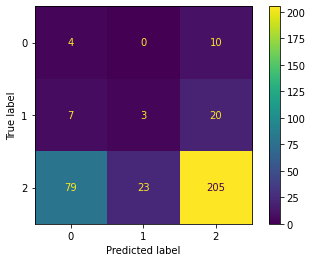

In [175]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()